In [1]:
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
import pandas as pd
from ydata_synthetic.synthesizers.timeseries import TimeGAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import os

2023-01-13 08:37:38.786139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
seq_len = 24        # Timesteps
n_seq = 10          # Features
hidden_dim = 24     # Hidden units for generator (GRU & LSTM).
                    # Also decides output_units for generator
gamma = 1           # Used for discriminator loss
noise_dim = 32      # Used by generator as a starter dimension
dim = 128           # UNUSED
batch_size = 128
learning_rate = 5e-4
beta_1 = 0          # UNUSED
beta_2 = 1          # UNUSED
data_dim = 28       # UNUSED

# batch_size, lr, beta_1, beta_2, noise_dim, data_dim, layers_dim
gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, data_dim, dim]

In [12]:
file_path = "energydata_complete.csv"
energy_df = pd.read_csv(file_path)
energy_df['date'] = pd.to_datetime(energy_df['date'])
energy_df = energy_df.set_index('date').sort_index()

# Data transformations to be applied prior to be used with the synthesizer model
energy_data = real_data_loading(energy_df.values, seq_len=seq_len)
print(len(energy_data), energy_data[0].shape)

19711 (24, 28)


In [13]:
energy_df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [14]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(energy_data, train_steps=500)

folders = os.listdir('Modelos')
folders.sort()
try:
    number = int(folders[-1].split('_')[1])+1
    folder = os.path.join('Modelos','model_'+str(number))
    os.mkdir(folder)
except:
    folder = os.path.join('Modelos','model_1')
    os.mkdir(folder)

synth.save(os.path.join(folder,'synth_energy.pkl'))

Emddeding network training:   0%|                       | 0/500 [00:01<?, ?it/s]


ValueError: in user code:

    /home/paulo/anaconda3/envs/myenv_time/lib/python3.8/site-packages/ydata_synthetic/synthesizers/timeseries/timegan/model.py:108 train_autoencoder  *
        x_tilde = self.autoencoder(x)
    /home/paulo/anaconda3/envs/myenv_time/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/paulo/anaconda3/envs/myenv_time/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_2: expected shape=(None, 24, 10), found shape=(128, 24, 28)


In [26]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
folder = 'Modelos/model_2'
synth.load(os.path.join(folder,'synth_energy.pkl'))

In [27]:
synth_data = synth.sample(len(energy_data))

Synthetic data generation: 100%|█████████████████████████████████████████████████████| 154/154 [00:28<00:00,  5.49it/s]


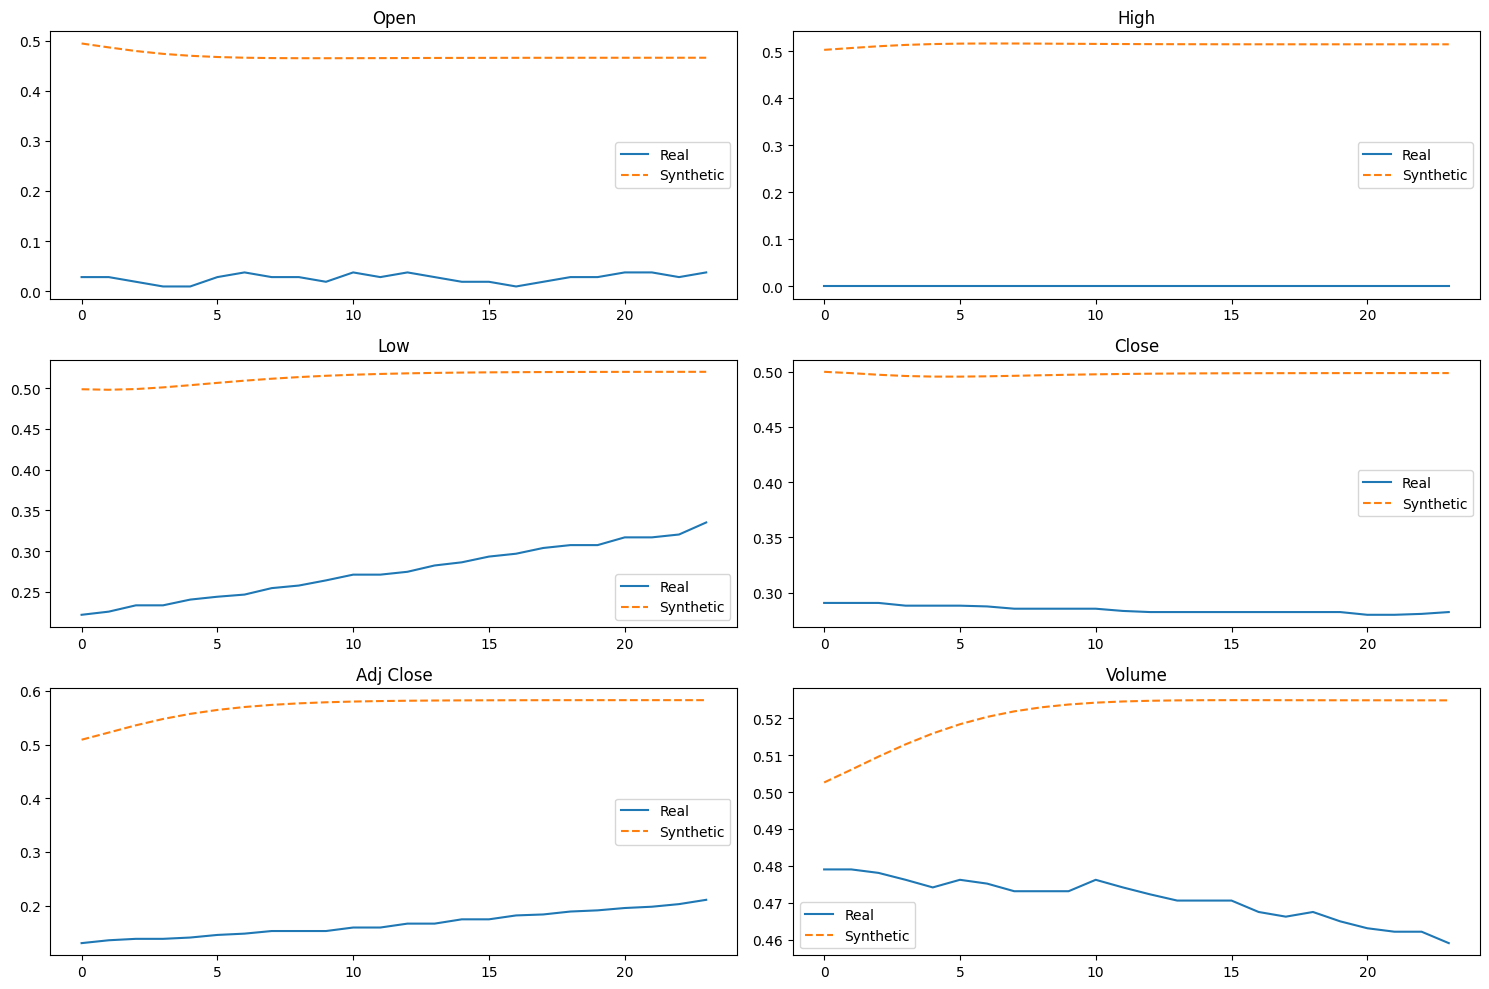

In [28]:
cols = ['Open','High','Low','Close','Adj Close','Volume']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(energy_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': energy_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

In [29]:
sample_size = 250
idx = np.random.permutation(len(energy_data))[:sample_size]

real_sample = np.asarray(energy_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

# For the purpose of comparison we need the data to be 2-Dimensional.
# For that reason we are going to use only two components for both the PCA and TSNE.
# synth_data_reduced: {ndarray: (7000, 24)}
# energy_data_reduced: {ndarray: (7000, 24)}
synth_data_reduced = real_sample.reshape(-1, seq_len)
energy_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

# The fit of the methods must be done only using the real sequential data
pca.fit(energy_data_reduced)

# pca_real: {DataFrame: (7000, 2)}
# pca_synth: {DataFrame: (7000, 2)}
pca_real = pd.DataFrame(pca.transform(energy_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

# data_reduced: {ndarray: (14000, 24)}
data_reduced = np.concatenate((energy_data_reduced, synth_data_reduced), axis=0)

# tsne_results: {DataFrame: (14000, 2)}
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

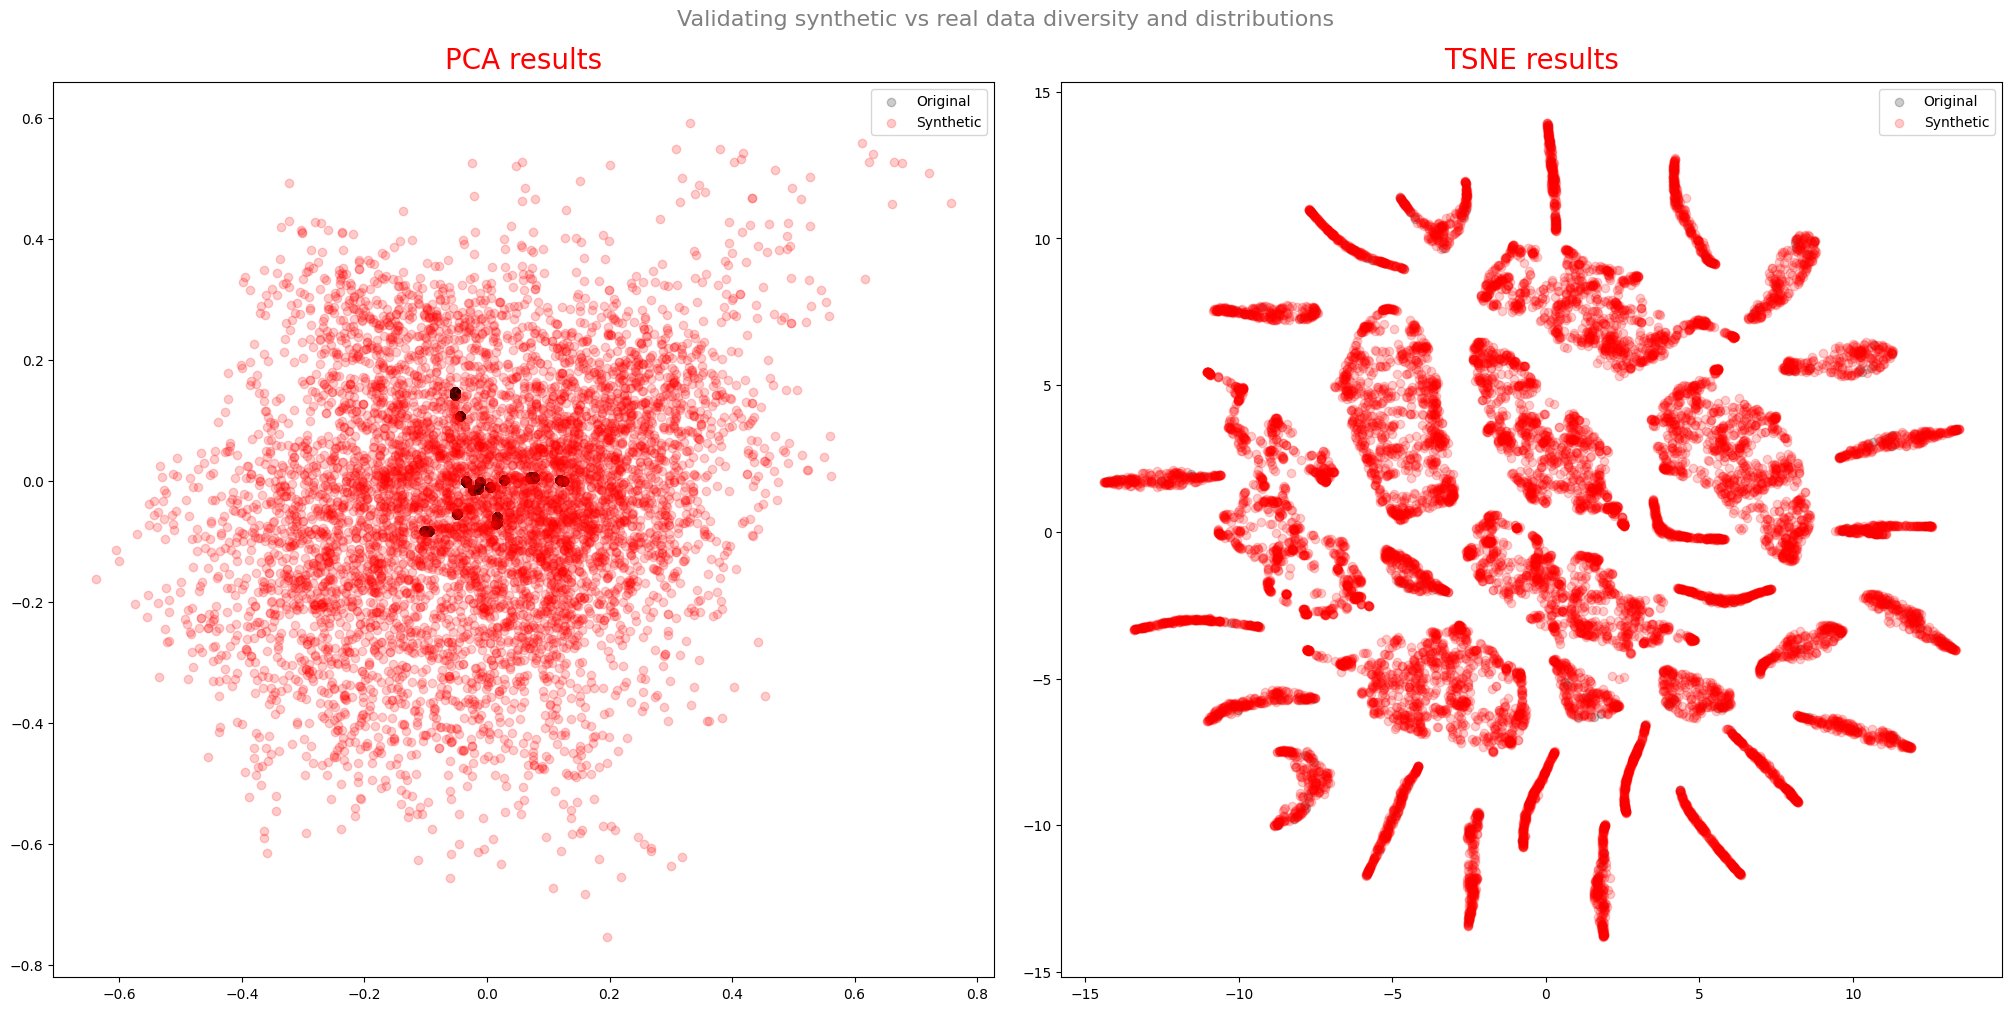

In [30]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')